In [1]:
import torch
import wget
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np

%matplotlib inline

In [2]:
#Use if dataset.MNIST is not eble to download the files
#wget.download('http://www.di.ens.fr/~lelarge/MNIST.tar.gz')
#!tar -zxvf MNIST.tar.gz;

In [3]:
#Download the dataset
mnist_train = datasets.MNIST('./', train=True, download=True, transform=transforms.ToTensor())
mnist_val = datasets.MNIST('./', train=False, download=True, transform=transforms.ToTensor())

In [4]:
#Definition of the Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
#Definition of the Training Pipeline

def train(model, num_epochs=20, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() 
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) 
    train_loader = torch.utils.data.DataLoader(mnist_train, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    
    val_loader = torch.utils.data.DataLoader(mnist_val, 
                                               batch_size=batch_size, 
                                               shuffle=False)
    outputs = []
    for epoch in range(num_epochs):
        running_loss = 0
        num_batches_epoch = 0
        model.train()
        for data in train_loader:
            img, _ = data
            #Noise is added to the input images
            noisy = np.clip(img + np.random.normal(0, 0.6, img.shape).astype('float32'),0,1)
            recon = model(noisy)
            #The Network should output the image without noise
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            num_batches_epoch += 1
            running_loss += loss.item()
        
        train_loss = running_loss/num_batches_epoch
        
        running_loss = 0
        num_batches_epoch = 0
        model.eval()
        for data in val_loader:
            img, _ = data
            noisy = np.clip(img + np.random.normal(0, 0.6, img.shape).astype('float32'),0,1)
            recon = model(noisy)
            loss = criterion(recon, img)
            num_batches_epoch += 1
            running_loss += loss.item()
        val_loss = running_loss/num_batches_epoch
        
        print('Epoch:{}, Train Loss:{:.4f}, Validation Loss:{:.4f}'.format(epoch+1, train_loss, val_loss))
        outputs.append((epoch, noisy, recon))
    return outputs

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Autoencoder()
model.to(device)

max_epochs = 5
outputs = train(model, num_epochs=max_epochs)

cpu
Epoch:1, Train Loss:0.0339, Validation Loss:0.0166
Epoch:2, Train Loss:0.0157, Validation Loss:0.0149
Epoch:3, Train Loss:0.0149, Validation Loss:0.0144
Epoch:4, Train Loss:0.0145, Validation Loss:0.0142
Epoch:5, Train Loss:0.0143, Validation Loss:0.0140


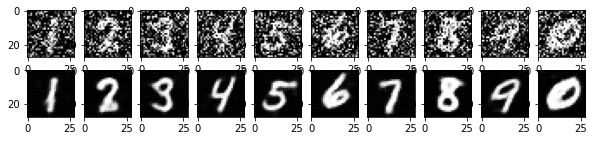

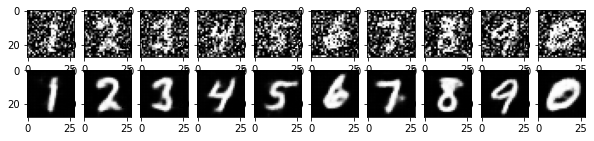

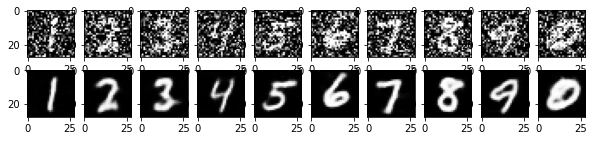

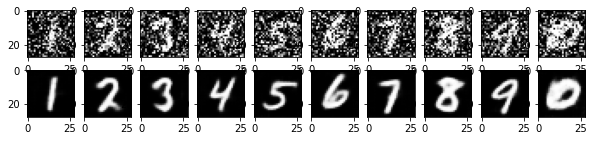

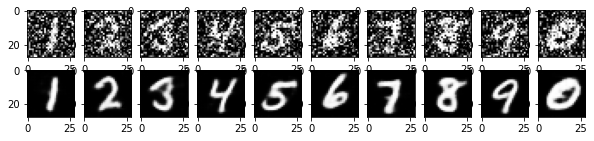

In [8]:
for k in range(0, max_epochs):
    plt.figure(figsize=(10, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 10: break
        plt.subplot(2, 10, i+1)
        plt.imshow(item[0], cmap=plt.cm.gray)
        
    for i, item in enumerate(recon):
        if i >= 10: break
        plt.subplot(2, 10, 10+i+1)
        plt.imshow(item[0], cmap=plt.cm.gray)